## Enron1 Dataset EDA
In this EDA, I would like to focus on getting a basic understanding of trends in the text data presented in Enron1 dataset and do some topic modeling to see if there is a significant difference in the contents of spam and non-spam emails.

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis.sklearn
import pyLDAvis
from IPython.core.display import display, HTML
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Let's drop *'Unnamed: 0'* column and some of the rows containing null values in *'lemmatized'* and *'stemmed'* columns:

In [2]:
df = pd.read_csv('spam_dataset_preprocessed.csv')
df.drop('Unnamed: 0', axis=1, inplace = True)
df.head()

,class,mail,label,lemmatized,stemmed
0,real,Subject: enron methanol ; meter # : 988291\r\n...,0,methanol meter follow note give monday prelimi...,methanol meter follow note gave monday prelimi...
1,real,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,hpl nom january see attach file hplnol xl hpln...,hpl nom januari see attach file hplnol xl hpln...
2,real,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,neon retreat ho ho ho around wonderful time ye...,neon retreat ho ho ho around wonder time year ...
3,spam,"Subject: photoshop , windows , office . cheap ...",1,photoshop windows office cheap main trend abas...,photoshop window offic cheap main trend abas d...
4,real,Subject: re : indian springs\r\nthis deal is t...,0,indian spring deal book teco pvr revenue under...,indian spring deal book teco pvr revenu unders...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 5 columns):
class         5171 non-null object
mail          5171 non-null object
label         5171 non-null int64
lemmatized    5153 non-null object
stemmed       5153 non-null object
dtypes: int64(1), object(4)
memory usage: 202.1+ KB


In [4]:
df.isnull().sum()

class          0
mail           0
label          0
lemmatized    18
stemmed       18
dtype: int64

In [5]:
df[df.isnull().any(axis=1)]

,class,mail,label,lemmatized,stemmed
154,spam,Subject: \r\n,1,NaN,NaN
182,spam,Subject: \r\n,1,NaN,NaN
296,spam,Subject: \r\n,1,NaN,NaN
363,spam,Subject: \r\n,1,NaN,NaN
1130,spam,Subject: \r\n,1,NaN,NaN
1279,spam,Subject: \r\n,1,NaN,NaN
1369,spam,Subject: \r\n,1,NaN,NaN
1508,spam,Subject: re [ 8 ]\r\n,1,NaN,NaN
2184,spam,Subject: \r\n,1,NaN,NaN
2538,spam,Subject: \r\n,1,NaN,NaN


In [6]:
df = df.dropna()
df.isnull().sum()

class         0
mail          0
label         0
lemmatized    0
stemmed       0
dtype: int64

Now, let's see whether our dataset is balanced or not:

In [7]:
spam = df.loc[df['label'] == 1]
real = df.loc[df['label'] == 0]
print('Spam email percentage:', len(spam) / (len(real) + len(spam)) * 100)
print('Regular email percentage:', len(real) / (len(real) + len(spam)) * 100)

Spam email percentage: 28.740539491558316
Regular email percentage: 71.25946050844169


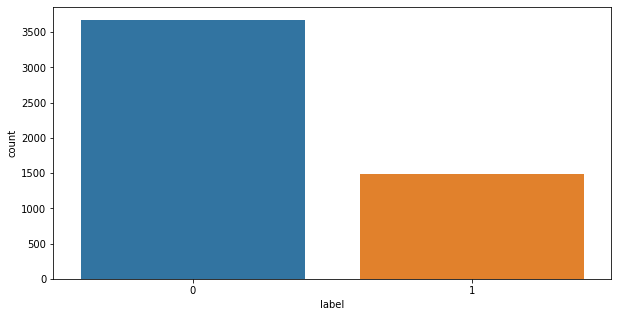

In [8]:
plt.figure(figsize = (10, 5))
sns.countplot(data = df, x = 'label');

I observe ~30/70 spam/non-spam split in our dataset, which is something to keep in mind when doing ML modeling. 

Also, taking a look at a couple of examples from the dataset is helpful to get a general sense of the data at hand:

In [9]:
print('SPAM EMAIL EXAMPLE:\n', df.iloc[3].mail, '\nNOT SPAM EMAIL EXAMPLE:\n', df.iloc[4].mail)

SPAM EMAIL EXAMPLE:
 Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin
 
NOT SPAM EMAIL EXAMPLE:
 Subject: re : indian springs
this deal is to book the teco pvr revenue . it is my understanding that teco
just sends us a check , i haven ' t received an answer as to whether there is a
predermined price associated with this deal or if teco just lets us know what
we are giving . i can continue to chase this deal down if you need .


To get a better sense of the text data that I am working with, I will create two wordcloud-type graphs for spam and non-spam emails:

In [10]:
def make_word_cloud(df):
    words = df['lemmatized']
    clas = df['class'].iloc[0]
    all_words = []
    for l in words:
        l = l.split(' ')
        all_words.extend(l)

    m_common = FreqDist(all_words).most_common(100)
    wordcloud = WordCloud(width=500, height=200, background_color='white').generate(str(m_common))
    fig = plt.figure(figsize=(12,6), facecolor='white')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f'Top 100 Most Common Words in {clas} emails', fontsize=30)
    plt.tight_layout(pad=0)
    #plt.show()
    plt.savefig(f'{clas}cloud.png')

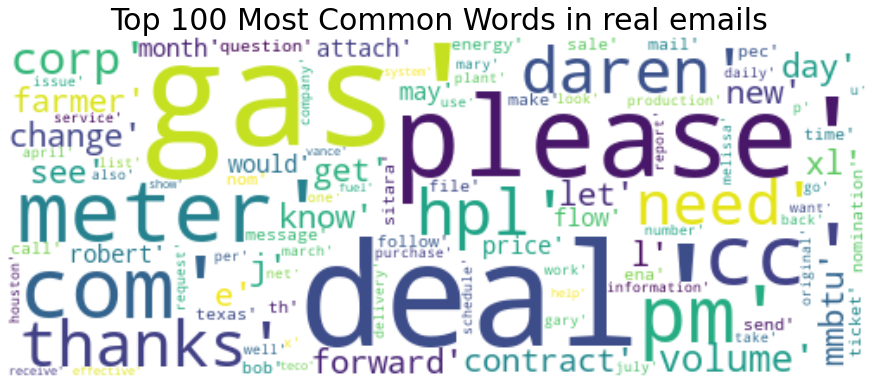

In [11]:
make_word_cloud(real)

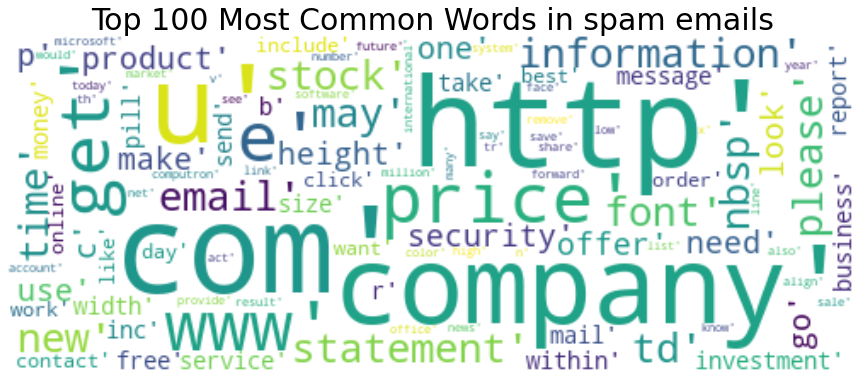

In [12]:
make_word_cloud(spam)

Based on the spam and non-spam wordclouds, there are significant lexical and topical differences between the two types of emails - spam emails tend to be more centered around finance, internet and business, while non-spam emails contain more conversational vocabulary. This phenomena is illustrated in the word frequency histograms below as well:

In [13]:
def plot_freq(df):
    words = df['lemmatized']
    clas = df['class'].iloc[0]
    all_words = []
    for l in words:
        l = l.split(' ')
        all_words.extend(l)

    common_top = FreqDist(all_words).most_common(25)
    x, y = zip(*common_top)

    fig = plt.figure(figsize=(12,6), facecolor='white')
    plt.margins(0.02)
    plt.bar(x, y)
    plt.xlabel('Words', fontsize=15)
    plt.ylabel('Word Count', fontsize=15)
    plt.yticks(fontsize=10)
    plt.xticks(rotation=60, fontsize=10)
    plt.title(f'Frequency of 25 Most Common Words in {clas} emails', fontsize=20)
    #plt.show()
    plt.savefig(f'{clas}freq.png')

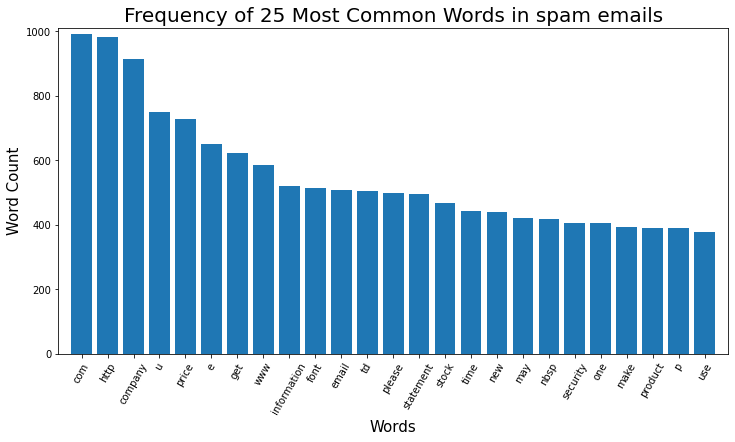

In [14]:
plot_freq(spam)

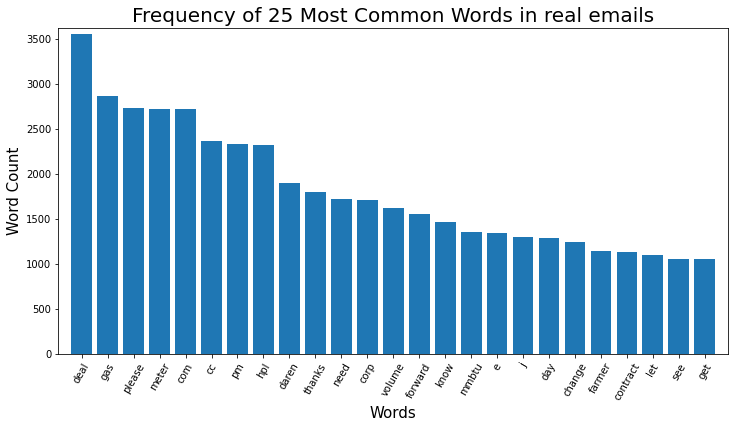

In [15]:
plot_freq(real)

At this point, to get a better sense of the topics presented in the two types of emails, I would like to encode the data using a bag-of-words method and use this encoding for LDA modeling. I decided to create top 5 topics that include top 5 most frequent words in them:

In [9]:
def encode_data(df):
    tf_vect = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
    tf = tf_vect.fit_transform(df['lemmatized'].values)
    tf_feature_names = tf_vect.get_feature_names()
    pd_tf = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
    return tf, tf_feature_names, pd_tf

spam_tf, spam_feature_names, pd_spam_tf = encode_data(spam)
real_tf, real_feature_names, pd_real_tf = encode_data(real)

In [10]:
def model_topics(tf, features, topic_num=5, top_w_num=5):
    lda_model = LatentDirichletAllocation(n_components=topic_num, learning_method='online', max_iter=500, random_state=0).fit(tf)
    top_words = top_w_num
    for topic_idx, topic in enumerate(lda_model.components_):
        print(f"Topic {topic_idx+1}: ", " ".join([features[i] for i in topic.argsort()[:-top_words - 1:-1]]))
        
    return lda_model

lda_model_spam = model_topics(spam_tf, spam_feature_names)
print('\n')
lda_model_real = model_topics(real_tf, real_feature_names)

Topic 1:  get http pill com online
Topic 2:  http font td com email
Topic 3:  price software xp adobe microsoft
Topic 4:  com computron www contact message
Topic 5:  company statement stock security information


Topic 1:  gas meter corp cc mmbtu
Topic 2:  please need would know get
Topic 3:  deal meter hpl daren gas
Topic 4:  xl hpl pec nom com
Topic 5:  com message mail send please


Based on the top 5 most frequent words from each topic, we can deduce an estimate of the topic names:

Spam emails:\
Topic 1: Get drugs online\
Topic 2: Access bank online\
Topic 3: Purchase of sofware\
Topic 4: Buy stuff(?) online\
Topic 5: Financial services

Non-spam emails:\
Topic 1: Gas station search\
Topic 2: Request for something\
Topic 3: Gas-related conversation\
Topic 4: (?)\
Topic 5: Request to send an email/message

I am going to create spam and non-spam LDA model visualizations to get a clearer and more intuitive understanding of how the discovered topics and the words in them relate to each other. LDA web visualizations are served [here](http://127.0.0.1:8889/).

In [39]:
def make_panel(model, tf_vec, tf, feature_names, df):
    tf_vec.fit_transform(df['lemmatized'].values)
    tf_vec._validate_vocabulary()
    pyLDAvis.enable_notebook()
    prep(model, tf, tf_vec, feature_names)
    panel = pyLDAvis.sklearn.prepare(model, tf, tf_vec, mds='tsne', vocab=feature_names)
    html = pyLDAvis.prepared_data_to_html(panel)
    display(HTML(html))

In [40]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
make_panel(lda_model_spam, tf_vectorizer, spam_tf, spam_feature_names, spam)

In [41]:
make_panel(lda_model_real, tf_vectorizer, real_tf, real_feature_names, real)

TF-IDF algorithm is particularly useful for topic modeling as well. Moreover, it is great for encoding our dataset so that it can be used for training of ML models. Therefore, let's create tf-idf dataset encoding and save both tf-idf and bag-of-words representations for the next step of the project - ML modeling.

In [42]:
def encode_data_tf(df):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(df['lemmatized'])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    pd_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
    return tfidf, tfidf_feature_names, pd_tfidf

spam_tfidf, spam_feature_names_idf, pd_spam_idf = encode_data_tf(spam)
real_tfidf, real_feature_names_idf, pd_real_idf = encode_data_tf(real)

In [ ]:
_, _, pd_tfidf = encode_data_tf(df)
_, _, pd_tf = encode_data(df)
labels = df['label']
labels.reset_index(inplace=True, drop=True)
pd_tfidf.reset_index(inplace=True)
pd_tf.reset_index(inplace=True)
pd_tf_f = pd.concat([labels, pd_tf], axis=1)
pd_tfidf_f = pd.concat([labels, pd_tfidf], axis=1)

In [ ]:
pd_tfidf_f.to_csv('tfidf_dataset.csv')
pd_tf_f.to_csv('word_bag_dataset.csv')

Finally, I would like to explore another interesting technique that can be used for topic modeling - Non-negative matrix factorization (NMF). Let's see how this technique's produced topics compare to the ones genrated by our LDA models:

In [43]:
def model_topics_tf(tfidf, features, topic_num=5, top_w_num=5):
    nmf = NMF(n_components=topic_num, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
    top_words = top_w_num
    for topic_idx, topic in enumerate(nmf.components_):
        print(f"Topic {topic_idx+1}: ", " ".join([features[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    return nmf

nmf_spam = model_topics_tf(spam_tfidf, spam_feature_names_idf)
print('\n')
nmf_real = model_topics_tf(real_tfidf, real_feature_names_idf)

Topic 1:  prescription cialis get viagra pill
Topic 2:  company statement stock security investment
Topic 3:  computron contact message com remove
Topic 4:  xp software adobe window professional
Topic 5:  http com www want pain


Topic 1:  xl hplno file see hplo
Topic 2:  deal meter daren volume please
Topic 3:  hpl tap teco actuals iferc
Topic 4:  tu com utility actual texas
Topic 5:  nomination mmbtu eastrans calpine fuel


This technique produced a bit less vague topics that are easier to interpret.
Based on the top 5 most frequent words from each topic, we can deduce an estimate of the topic names:

Spam emails:\
Topic 1: Get drugs online - drug advertisements\
Topic 2: Financial services ads\
Topic 3: Contact online\
Topic 4: Buy software - commercial software advertisements\
Topic 5: (?)

Non-spam emails:\
Topic 1: (?)\
Topic 2: Request for something\
Topic 3: Gas-related info\
Topic 4: Utility bills\
Topic 5: Fuel-related info